# Regression Model 1


In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from math import sin, cos, sqrt, atan2, radians
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('Train set', train.shape)
print('Test set', test.shape)

Train set (1458644, 11)
Test set (625134, 9)


## Feature Engineering

### Target variable의 로그 변환

In [3]:
# trip_duration is highly skewed --> log transformation
train['log_trip_duration'] = np.log1p(train['trip_duration'])

## Feature Extraction 함수들 정의
1. Time 관련 feature 생성
2. 택시 이동 거리 계산
3. 택시 이동 방향

In [4]:
def time_feats(dataset):
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'])
    #dataset['dropoff_datetime'] = pd.to_datetime(dataset['dropoff_datetime'])

    dataset['pickup_hour'] = dataset['pickup_datetime'].dt.hour
    #dataset['dropoff_hour'] = dataset['dropoff_datetime'].dt.hour
    dataset['pickup_weekday'] = dataset['pickup_datetime'].dt.weekday
    #dataset['dropoff_weekday'] = dataset['dropoff_datetime'].dt.weekday
    return dataset

train = time_feats(train)
test = time_feats(test)

# trip distance
def calculateDistance(row):
    R = 6373.0 # approximate radius of earth in km
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

train['trip_distance'] = train.apply(lambda x: calculateDistance(x), axis = 1)
test['trip_distance'] = test.apply(lambda x: calculateDistance(x), axis = 1)

# speed
train['avg_speed'] = train['trip_distance']/train['trip_duration']

# direction of travel
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train['bearing'] = train.apply(lambda row:calculateBearing(row['pickup_latitude'],row['pickup_longitude'],
                                                         row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
test['bearing'] = test.apply(lambda row:calculateBearing(row['pickup_latitude'],row['pickup_longitude'],
                                                         row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

In [5]:
# remove outliers 
train = train[train['trip_duration'] < 1500000]

### Train vs Test set
모델링 전, train과 test set이 어떻게 다른지, 혹은 비슷한지를 비교하기 위해 간단한 시각화를 통해 살펴본다.
1. Datetime
 - Train과 test set의 날짜(date)별 택시 사용량 분포를 보면 각 데이터셋을 구성하는 날짜가 완벽하게 동일하고, 그 분포 또한 거의 비슷하므로 train과 test set은 랜덤하게 선택되었다는 것을 확인할 수 있음
2. Location
 - Train과 test set의 location data(longitude, latitude)분포를 확인했을 때, 지역 분포가 거의 동일함을 확인

<br>
따라서, feature extraction을 할 때 전체 데이터셋(train, test set)을 이용하면 된다. 

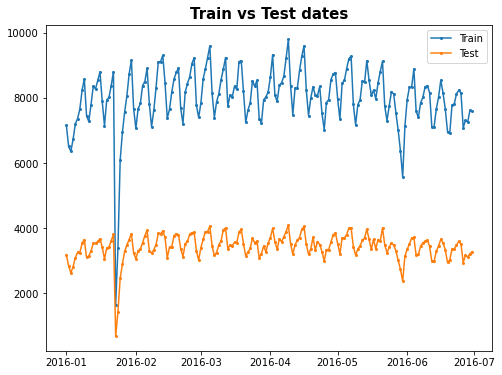

In [6]:
train['pickup_date'] = train['pickup_datetime'].dt.date
test['pickup_date'] = test['pickup_datetime'].dt.date

plt.figure(figsize = (8, 6))
plt.subplot(1, 1, 1)
plt.plot(train.groupby(['pickup_date'])['id'].count(), marker = 'o', markersize = 2, label = 'Train')
plt.plot(test.groupby(['pickup_date'])['id'].count(), marker = 'o', markersize = 2, label = 'Test')
plt.title('Train vs Test dates', fontsize = 15, fontweight = 'bold')
plt.legend()
plt.show()

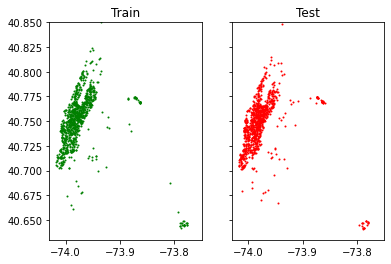

In [7]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:1000], train['pickup_latitude'].values[:1000],  color = 'green', s = 1)
ax[1].scatter(test['pickup_longitude'].values[:1000], test['pickup_latitude'].values[:1000], color = 'red', s = 1)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

### KMeans를 이용한 location data 클러스터링

In [8]:
# cluster pickup and dropoff locations: KMeans
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

kmeans = KMeans(n_clusters = 8, init = 'k-means++')
kmeans.fit(coords)

train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

### PCA로 location data 다르게 표현하기
PCA를 하는 이유는 location data의 variance를 최대한 반영하고, orthogonal한 변수들(components)을 생성하기 위함이다. 아래 그래프를 보면, 방향만 달라지고 location data의 shape은 잘 유지하는 것을 확인할 수 있다.

In [9]:
# PCA for location data
pca = PCA(n_components = 2).fit(coords)

train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

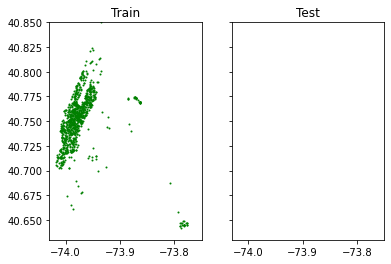

In [10]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:1000], train['pickup_latitude'].values[:1000],  color = 'green', s = 1)
ax[1].scatter(train['pickup_pca0'].values[:1000], train['pickup_pca1'].values[:1000], color = 'red', s = 1)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

### Feature Aggregation
Pickup, dropoff 클러스터, pickup 시간, 요일에 따라 trip duration과 average speed를 모델 feature로 구성하기 위해 aggregation을 진행한다.

In [11]:
# add aggregated features
agg_cols = ['pickup_cluster', 'dropoff_cluster', 'pickup_hour', 'pickup_weekday']

for col in agg_cols:
    gp = train.groupby(col).mean()[['log_trip_duration', 'avg_speed']]
    gp.columns = ['%s_gp_%s' % (col2, col) for col2 in gp.columns]
    train = pd.merge(train, gp, how = 'left', left_on = col, right_index = True)
    test = pd.merge(test, gp, how = 'left', left_on = col, right_index = True)

추가적으로, 전체 택스 루트 중 각 pickup과 dropoff 클러스터 조합에 해당하는 택시 사용량과 평균 속도를 feature로 추가한다.

In [12]:
cluster_comb = ['pickup_cluster', 'dropoff_cluster']
cluster_speed = train.groupby(cluster_comb).mean()[['avg_speed']].reset_index()
cluster_cnt = train.groupby(cluster_comb).count()[['id']].reset_index()
cluster_duration = train.groupby(cluster_comb).mean()[['log_trip_duration']].reset_index()
cluster = pd.merge(cluster_speed, cluster_cnt, on = cluster_comb)
cluster.columns = cluster_comb + ['avg_speed_%s' % '_'.join(cluster_comb), 'cnt_%s' %  '_'.join(cluster_comb)]

train = pd.merge(train, cluster, how='left', on = cluster_comb)
test = pd.merge(test, cluster, how='left', on = cluster_comb)

In [13]:
cluster.head(5)

,pickup_cluster,dropoff_cluster,avg_speed_pickup_cluster_dropoff_cluster,cnt_pickup_cluster_dropoff_cluster
0,0,0,0.002953,363617
1,0,2,0.004097,146879
2,0,3,0.008286,7530
3,0,4,0.006125,20631
4,0,5,1.910972,1


In [14]:
train.drop(['id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
            'pickup_datetime', 'dropoff_datetime', 'pickup_date',
            'log_trip_duration', 'avg_speed'], axis = 1, inplace = True)
test.drop(['id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_datetime', 'pickup_date'], axis = 1, inplace = True)

print(train.shape)
print(test.shape)

(1458640, 24)
(625134, 23)


In [16]:
# categorical variables with object categories
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [69]:
train.to_csv('new_train.csv', index = False)
test.to_csv('new_test.csv', index = False)

## Simple LGBMRegressor with KFold
 + Baseline Model - RMSLE 0.3952
 + KFold CV 적용
 + Hyperparameter tuning 없이 진행

In [35]:
# random parameter
lgb_params = {'n_estimators': 1500,
              'num_leaves': 15,
              'max_depth': 20,
              'objective': 'regression',
              'min_child_samples': 15,
              'subsample': 0.7,
              'random_state': 0
              }

In [36]:
class KFoldModel(object):
    def __init__(self, n_splits, model):
        self.n_splits = n_splits
        self.model = model
        
    def prediction(self, X, y, early_stopping):
        folds = list(KFold(n_splits = self.n_splits, shuffle = True, random_state = 0).split(X, y))
        
        fold_rmsle = []
        for i, (train_idx, val_idx) in enumerate(folds):
            X_train, X_val = X.iloc[train_idx, :], X.iloc[val_idx, :]
            y_train, y_val = y[train_idx], y[val_idx]
            
            if early_stopping:
                print('\n %s model: Fold %d' %(self.model.__class__.__name__, i+1))
                self.model.fit(X_train, y_train, eval_set = [(X_val, y_val)], eval_metric = 'rmse', 
                               early_stopping_rounds = 50)
            else:
                print('\n %s model: Fold %d' %(self.model.__class__.__name__, i+1))
                self.model.fit(X_train, y_train)
                
            y_val_pred = self.model.predict(X_val)
            rmsle = np.sqrt(mean_squared_error(y_val, y_val_pred))
            fold_rmsle.append(rmsle)
        return fold_rmsle

In [28]:
train['log_trip_duration'] = np.log1p(train['trip_duration'])
train.head()

,vendor_id,passenger_count,trip_duration,pickup_hour,pickup_weekday,trip_distance,bearing,pickup_cluster,dropoff_cluster,pickup_pca0,...,avg_speed_gp_dropoff_cluster,log_trip_duration_gp_pickup_hour,avg_speed_gp_pickup_hour,log_trip_duration_gp_pickup_weekday,avg_speed_gp_pickup_weekday,avg_speed_pickup_cluster_dropoff_cluster,cnt_pickup_cluster_dropoff_cluster,store_and_fwd_flag_N,store_and_fwd_flag_Y,log_trip_duration
0,2,1,455,17,0,1.498991,99.970196,0,6,0.007691,...,0.004511,6.537261,0.003472,6.426564,0.004200,0.004589,140570,1,0,6.122493
1,1,1,663,0,6,1.806074,-117.153768,0,2,0.007677,...,0.003997,6.422266,0.004909,6.377635,0.004639,0.004097,146879,1,0,6.498282
2,2,1,2124,11,1,6.387103,-159.680165,0,2,0.004803,...,0.003997,6.520644,0.003453,6.491503,0.003812,0.004097,146879,1,0,7.661527
3,2,1,429,19,2,1.485965,-172.737700,2,2,0.038342,...,0.003997,6.441269,0.003773,6.513662,0.003754,0.003444,203734,1,0,6.063785
4,2,1,435,13,5,1.188962,179.473585,6,6,-0.002877,...,0.004511,6.537807,0.003456,6.418952,0.004173,0.004051,180567,1,0,6.077642


In [32]:
X = train.drop(['trip_duration', 'log_trip_duration'], axis = 1)
y = train['log_trip_duration']

print(X.shape)
print(y.shape)

In [37]:
lgbm_model = LGBMRegressor(**lgb_params)
models = KFoldModel(n_splits = 5, model = lgbm_model)
cv_result = models.prediction(X, y, early_stopping = True)


 LGBMRegressor model: Fold 1
[1]	valid_0's rmse: 0.750403	valid_0's l2: 0.563104
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 0.709618	valid_0's l2: 0.503558
[3]	valid_0's rmse: 0.674465	valid_0's l2: 0.454904
[4]	valid_0's rmse: 0.644054	valid_0's l2: 0.414805
[5]	valid_0's rmse: 0.61812	valid_0's l2: 0.382073
[6]	valid_0's rmse: 0.595931	valid_0's l2: 0.355134
[7]	valid_0's rmse: 0.576816	valid_0's l2: 0.332717
[8]	valid_0's rmse: 0.56007	valid_0's l2: 0.313679
[9]	valid_0's rmse: 0.545801	valid_0's l2: 0.297899
[10]	valid_0's rmse: 0.533838	valid_0's l2: 0.284983
[11]	valid_0's rmse: 0.523142	valid_0's l2: 0.273677
[12]	valid_0's rmse: 0.513725	valid_0's l2: 0.263914
[13]	valid_0's rmse: 0.505983	valid_0's l2: 0.256018
[14]	valid_0's rmse: 0.498962	valid_0's l2: 0.248963
[15]	valid_0's rmse: 0.493001	valid_0's l2: 0.24305
[16]	valid_0's rmse: 0.48779	valid_0's l2: 0.237939
[17]	valid_0's rmse: 0.483431	valid_0's l2: 0.233706
[18]	valid_0's rmse: 

[158]	valid_0's rmse: 0.414918	valid_0's l2: 0.172157
[159]	valid_0's rmse: 0.414898	valid_0's l2: 0.17214
[160]	valid_0's rmse: 0.414747	valid_0's l2: 0.172015
[161]	valid_0's rmse: 0.414667	valid_0's l2: 0.171949
[162]	valid_0's rmse: 0.414631	valid_0's l2: 0.171919
[163]	valid_0's rmse: 0.414585	valid_0's l2: 0.171881
[164]	valid_0's rmse: 0.414529	valid_0's l2: 0.171834
[165]	valid_0's rmse: 0.414468	valid_0's l2: 0.171784
[166]	valid_0's rmse: 0.414394	valid_0's l2: 0.171723
[167]	valid_0's rmse: 0.414344	valid_0's l2: 0.171681
[168]	valid_0's rmse: 0.414236	valid_0's l2: 0.171592
[169]	valid_0's rmse: 0.414192	valid_0's l2: 0.171555
[170]	valid_0's rmse: 0.414183	valid_0's l2: 0.171547
[171]	valid_0's rmse: 0.41416	valid_0's l2: 0.171529
[172]	valid_0's rmse: 0.414142	valid_0's l2: 0.171514
[173]	valid_0's rmse: 0.414071	valid_0's l2: 0.171455
[174]	valid_0's rmse: 0.41398	valid_0's l2: 0.171379
[175]	valid_0's rmse: 0.413954	valid_0's l2: 0.171358
[176]	valid_0's rmse: 0.413918	

[311]	valid_0's rmse: 0.408504	valid_0's l2: 0.166875
[312]	valid_0's rmse: 0.408484	valid_0's l2: 0.166859
[313]	valid_0's rmse: 0.408476	valid_0's l2: 0.166852
[314]	valid_0's rmse: 0.408468	valid_0's l2: 0.166846
[315]	valid_0's rmse: 0.408439	valid_0's l2: 0.166823
[316]	valid_0's rmse: 0.4084	valid_0's l2: 0.166791
[317]	valid_0's rmse: 0.408383	valid_0's l2: 0.166777
[318]	valid_0's rmse: 0.408342	valid_0's l2: 0.166743
[319]	valid_0's rmse: 0.408308	valid_0's l2: 0.166716
[320]	valid_0's rmse: 0.408267	valid_0's l2: 0.166682
[321]	valid_0's rmse: 0.40825	valid_0's l2: 0.166668
[322]	valid_0's rmse: 0.408231	valid_0's l2: 0.166652
[323]	valid_0's rmse: 0.408197	valid_0's l2: 0.166624
[324]	valid_0's rmse: 0.408183	valid_0's l2: 0.166613
[325]	valid_0's rmse: 0.408149	valid_0's l2: 0.166585
[326]	valid_0's rmse: 0.408099	valid_0's l2: 0.166545
[327]	valid_0's rmse: 0.408082	valid_0's l2: 0.166531
[328]	valid_0's rmse: 0.408062	valid_0's l2: 0.166515
[329]	valid_0's rmse: 0.408052	

[468]	valid_0's rmse: 0.405405	valid_0's l2: 0.164353
[469]	valid_0's rmse: 0.405381	valid_0's l2: 0.164334
[470]	valid_0's rmse: 0.405361	valid_0's l2: 0.164318
[471]	valid_0's rmse: 0.405338	valid_0's l2: 0.164299
[472]	valid_0's rmse: 0.405338	valid_0's l2: 0.164298
[473]	valid_0's rmse: 0.405314	valid_0's l2: 0.164279
[474]	valid_0's rmse: 0.405294	valid_0's l2: 0.164263
[475]	valid_0's rmse: 0.405293	valid_0's l2: 0.164263
[476]	valid_0's rmse: 0.405275	valid_0's l2: 0.164248
[477]	valid_0's rmse: 0.405255	valid_0's l2: 0.164232
[478]	valid_0's rmse: 0.405239	valid_0's l2: 0.164219
[479]	valid_0's rmse: 0.40524	valid_0's l2: 0.164219
[480]	valid_0's rmse: 0.405253	valid_0's l2: 0.16423
[481]	valid_0's rmse: 0.405237	valid_0's l2: 0.164217
[482]	valid_0's rmse: 0.40523	valid_0's l2: 0.164211
[483]	valid_0's rmse: 0.405199	valid_0's l2: 0.164186
[484]	valid_0's rmse: 0.405198	valid_0's l2: 0.164185
[485]	valid_0's rmse: 0.405198	valid_0's l2: 0.164185
[486]	valid_0's rmse: 0.405188	

[624]	valid_0's rmse: 0.403521	valid_0's l2: 0.16283
[625]	valid_0's rmse: 0.403515	valid_0's l2: 0.162824
[626]	valid_0's rmse: 0.403517	valid_0's l2: 0.162826
[627]	valid_0's rmse: 0.403516	valid_0's l2: 0.162825
[628]	valid_0's rmse: 0.403495	valid_0's l2: 0.162809
[629]	valid_0's rmse: 0.403487	valid_0's l2: 0.162802
[630]	valid_0's rmse: 0.403476	valid_0's l2: 0.162793
[631]	valid_0's rmse: 0.403452	valid_0's l2: 0.162774
[632]	valid_0's rmse: 0.403448	valid_0's l2: 0.16277
[633]	valid_0's rmse: 0.40342	valid_0's l2: 0.162748
[634]	valid_0's rmse: 0.403412	valid_0's l2: 0.162741
[635]	valid_0's rmse: 0.403413	valid_0's l2: 0.162742
[636]	valid_0's rmse: 0.40342	valid_0's l2: 0.162748
[637]	valid_0's rmse: 0.403422	valid_0's l2: 0.162749
[638]	valid_0's rmse: 0.40341	valid_0's l2: 0.162739
[639]	valid_0's rmse: 0.403384	valid_0's l2: 0.162718
[640]	valid_0's rmse: 0.403384	valid_0's l2: 0.162718
[641]	valid_0's rmse: 0.403365	valid_0's l2: 0.162704
[642]	valid_0's rmse: 0.40336	val

[784]	valid_0's rmse: 0.402096	valid_0's l2: 0.161681
[785]	valid_0's rmse: 0.402092	valid_0's l2: 0.161678
[786]	valid_0's rmse: 0.402069	valid_0's l2: 0.161659
[787]	valid_0's rmse: 0.402051	valid_0's l2: 0.161645
[788]	valid_0's rmse: 0.402047	valid_0's l2: 0.161642
[789]	valid_0's rmse: 0.402042	valid_0's l2: 0.161638
[790]	valid_0's rmse: 0.402039	valid_0's l2: 0.161635
[791]	valid_0's rmse: 0.402035	valid_0's l2: 0.161632
[792]	valid_0's rmse: 0.40203	valid_0's l2: 0.161628
[793]	valid_0's rmse: 0.402017	valid_0's l2: 0.161618
[794]	valid_0's rmse: 0.401999	valid_0's l2: 0.161603
[795]	valid_0's rmse: 0.401995	valid_0's l2: 0.1616
[796]	valid_0's rmse: 0.401987	valid_0's l2: 0.161594
[797]	valid_0's rmse: 0.401973	valid_0's l2: 0.161582
[798]	valid_0's rmse: 0.401968	valid_0's l2: 0.161578
[799]	valid_0's rmse: 0.401955	valid_0's l2: 0.161568
[800]	valid_0's rmse: 0.401947	valid_0's l2: 0.161561
[801]	valid_0's rmse: 0.401932	valid_0's l2: 0.161549
[802]	valid_0's rmse: 0.401925	

[943]	valid_0's rmse: 0.401094	valid_0's l2: 0.160877
[944]	valid_0's rmse: 0.401086	valid_0's l2: 0.16087
[945]	valid_0's rmse: 0.40109	valid_0's l2: 0.160873
[946]	valid_0's rmse: 0.401088	valid_0's l2: 0.160872
[947]	valid_0's rmse: 0.401082	valid_0's l2: 0.160867
[948]	valid_0's rmse: 0.401084	valid_0's l2: 0.160868
[949]	valid_0's rmse: 0.401075	valid_0's l2: 0.160861
[950]	valid_0's rmse: 0.401072	valid_0's l2: 0.160858
[951]	valid_0's rmse: 0.401067	valid_0's l2: 0.160854
[952]	valid_0's rmse: 0.40106	valid_0's l2: 0.160849
[953]	valid_0's rmse: 0.401067	valid_0's l2: 0.160855
[954]	valid_0's rmse: 0.401065	valid_0's l2: 0.160854
[955]	valid_0's rmse: 0.401062	valid_0's l2: 0.16085
[956]	valid_0's rmse: 0.401057	valid_0's l2: 0.160847
[957]	valid_0's rmse: 0.401046	valid_0's l2: 0.160838
[958]	valid_0's rmse: 0.401029	valid_0's l2: 0.160824
[959]	valid_0's rmse: 0.401023	valid_0's l2: 0.16082
[960]	valid_0's rmse: 0.401023	valid_0's l2: 0.16082
[961]	valid_0's rmse: 0.401015	val

[1098]	valid_0's rmse: 0.400304	valid_0's l2: 0.160244
[1099]	valid_0's rmse: 0.400307	valid_0's l2: 0.160246
[1100]	valid_0's rmse: 0.400295	valid_0's l2: 0.160236
[1101]	valid_0's rmse: 0.400304	valid_0's l2: 0.160244
[1102]	valid_0's rmse: 0.400302	valid_0's l2: 0.160242
[1103]	valid_0's rmse: 0.400301	valid_0's l2: 0.160241
[1104]	valid_0's rmse: 0.400296	valid_0's l2: 0.160237
[1105]	valid_0's rmse: 0.400287	valid_0's l2: 0.16023
[1106]	valid_0's rmse: 0.400269	valid_0's l2: 0.160215
[1107]	valid_0's rmse: 0.400259	valid_0's l2: 0.160207
[1108]	valid_0's rmse: 0.400245	valid_0's l2: 0.160196
[1109]	valid_0's rmse: 0.400236	valid_0's l2: 0.160189
[1110]	valid_0's rmse: 0.400221	valid_0's l2: 0.160177
[1111]	valid_0's rmse: 0.400216	valid_0's l2: 0.160173
[1112]	valid_0's rmse: 0.400209	valid_0's l2: 0.160167
[1113]	valid_0's rmse: 0.40022	valid_0's l2: 0.160176
[1114]	valid_0's rmse: 0.400217	valid_0's l2: 0.160174
[1115]	valid_0's rmse: 0.400212	valid_0's l2: 0.160169
[1116]	valid

[1254]	valid_0's rmse: 0.39964	valid_0's l2: 0.159712
[1255]	valid_0's rmse: 0.399643	valid_0's l2: 0.159715
[1256]	valid_0's rmse: 0.399645	valid_0's l2: 0.159716
[1257]	valid_0's rmse: 0.399639	valid_0's l2: 0.159712
[1258]	valid_0's rmse: 0.399635	valid_0's l2: 0.159708
[1259]	valid_0's rmse: 0.399633	valid_0's l2: 0.159706
[1260]	valid_0's rmse: 0.399618	valid_0's l2: 0.159694
[1261]	valid_0's rmse: 0.399616	valid_0's l2: 0.159693
[1262]	valid_0's rmse: 0.399618	valid_0's l2: 0.159694
[1263]	valid_0's rmse: 0.399618	valid_0's l2: 0.159694
[1264]	valid_0's rmse: 0.399616	valid_0's l2: 0.159693
[1265]	valid_0's rmse: 0.399612	valid_0's l2: 0.15969
[1266]	valid_0's rmse: 0.399603	valid_0's l2: 0.159682
[1267]	valid_0's rmse: 0.399599	valid_0's l2: 0.159679
[1268]	valid_0's rmse: 0.399601	valid_0's l2: 0.159681
[1269]	valid_0's rmse: 0.3996	valid_0's l2: 0.15968
[1270]	valid_0's rmse: 0.399606	valid_0's l2: 0.159685
[1271]	valid_0's rmse: 0.399609	valid_0's l2: 0.159687
[1272]	valid_0'

[1409]	valid_0's rmse: 0.399194	valid_0's l2: 0.159356
[1410]	valid_0's rmse: 0.399189	valid_0's l2: 0.159352
[1411]	valid_0's rmse: 0.39918	valid_0's l2: 0.159344
[1412]	valid_0's rmse: 0.399174	valid_0's l2: 0.15934
[1413]	valid_0's rmse: 0.399162	valid_0's l2: 0.15933
[1414]	valid_0's rmse: 0.39916	valid_0's l2: 0.159329
[1415]	valid_0's rmse: 0.399151	valid_0's l2: 0.159322
[1416]	valid_0's rmse: 0.399145	valid_0's l2: 0.159317
[1417]	valid_0's rmse: 0.399143	valid_0's l2: 0.159315
[1418]	valid_0's rmse: 0.399133	valid_0's l2: 0.159307
[1419]	valid_0's rmse: 0.39913	valid_0's l2: 0.159305
[1420]	valid_0's rmse: 0.399126	valid_0's l2: 0.159302
[1421]	valid_0's rmse: 0.399122	valid_0's l2: 0.159299
[1422]	valid_0's rmse: 0.399121	valid_0's l2: 0.159298
[1423]	valid_0's rmse: 0.399119	valid_0's l2: 0.159296
[1424]	valid_0's rmse: 0.399113	valid_0's l2: 0.159291
[1425]	valid_0's rmse: 0.399114	valid_0's l2: 0.159292
[1426]	valid_0's rmse: 0.399107	valid_0's l2: 0.159286
[1427]	valid_0'

[58]	valid_0's rmse: 0.426916	valid_0's l2: 0.182257
[59]	valid_0's rmse: 0.426522	valid_0's l2: 0.181921
[60]	valid_0's rmse: 0.426155	valid_0's l2: 0.181608
[61]	valid_0's rmse: 0.425686	valid_0's l2: 0.181208
[62]	valid_0's rmse: 0.425287	valid_0's l2: 0.180869
[63]	valid_0's rmse: 0.424991	valid_0's l2: 0.180617
[64]	valid_0's rmse: 0.424546	valid_0's l2: 0.18024
[65]	valid_0's rmse: 0.424283	valid_0's l2: 0.180016
[66]	valid_0's rmse: 0.42381	valid_0's l2: 0.179615
[67]	valid_0's rmse: 0.423535	valid_0's l2: 0.179382
[68]	valid_0's rmse: 0.423132	valid_0's l2: 0.17904
[69]	valid_0's rmse: 0.422818	valid_0's l2: 0.178775
[70]	valid_0's rmse: 0.422564	valid_0's l2: 0.17856
[71]	valid_0's rmse: 0.42238	valid_0's l2: 0.178405
[72]	valid_0's rmse: 0.422074	valid_0's l2: 0.178146
[73]	valid_0's rmse: 0.421768	valid_0's l2: 0.177888
[74]	valid_0's rmse: 0.421471	valid_0's l2: 0.177638
[75]	valid_0's rmse: 0.420964	valid_0's l2: 0.177211
[76]	valid_0's rmse: 0.420634	valid_0's l2: 0.17693

[215]	valid_0's rmse: 0.406825	valid_0's l2: 0.165507
[216]	valid_0's rmse: 0.406793	valid_0's l2: 0.165481
[217]	valid_0's rmse: 0.406722	valid_0's l2: 0.165423
[218]	valid_0's rmse: 0.406668	valid_0's l2: 0.165379
[219]	valid_0's rmse: 0.406635	valid_0's l2: 0.165352
[220]	valid_0's rmse: 0.406581	valid_0's l2: 0.165308
[221]	valid_0's rmse: 0.406542	valid_0's l2: 0.165276
[222]	valid_0's rmse: 0.406522	valid_0's l2: 0.16526
[223]	valid_0's rmse: 0.406481	valid_0's l2: 0.165227
[224]	valid_0's rmse: 0.406459	valid_0's l2: 0.165209
[225]	valid_0's rmse: 0.406386	valid_0's l2: 0.16515
[226]	valid_0's rmse: 0.406359	valid_0's l2: 0.165128
[227]	valid_0's rmse: 0.406342	valid_0's l2: 0.165114
[228]	valid_0's rmse: 0.406261	valid_0's l2: 0.165048
[229]	valid_0's rmse: 0.406204	valid_0's l2: 0.165002
[230]	valid_0's rmse: 0.406182	valid_0's l2: 0.164984
[231]	valid_0's rmse: 0.406155	valid_0's l2: 0.164962
[232]	valid_0's rmse: 0.40611	valid_0's l2: 0.164925
[233]	valid_0's rmse: 0.406076	

[371]	valid_0's rmse: 0.402324	valid_0's l2: 0.161865
[372]	valid_0's rmse: 0.402298	valid_0's l2: 0.161844
[373]	valid_0's rmse: 0.402262	valid_0's l2: 0.161814
[374]	valid_0's rmse: 0.402242	valid_0's l2: 0.161799
[375]	valid_0's rmse: 0.402215	valid_0's l2: 0.161777
[376]	valid_0's rmse: 0.402188	valid_0's l2: 0.161755
[377]	valid_0's rmse: 0.402177	valid_0's l2: 0.161746
[378]	valid_0's rmse: 0.402183	valid_0's l2: 0.161751
[379]	valid_0's rmse: 0.402179	valid_0's l2: 0.161748
[380]	valid_0's rmse: 0.402151	valid_0's l2: 0.161726
[381]	valid_0's rmse: 0.402119	valid_0's l2: 0.1617
[382]	valid_0's rmse: 0.402102	valid_0's l2: 0.161686
[383]	valid_0's rmse: 0.402094	valid_0's l2: 0.161679
[384]	valid_0's rmse: 0.402063	valid_0's l2: 0.161654
[385]	valid_0's rmse: 0.402009	valid_0's l2: 0.161611
[386]	valid_0's rmse: 0.401978	valid_0's l2: 0.161586
[387]	valid_0's rmse: 0.401985	valid_0's l2: 0.161592
[388]	valid_0's rmse: 0.401968	valid_0's l2: 0.161578
[389]	valid_0's rmse: 0.401964

[523]	valid_0's rmse: 0.399877	valid_0's l2: 0.159902
[524]	valid_0's rmse: 0.39985	valid_0's l2: 0.15988
[525]	valid_0's rmse: 0.399827	valid_0's l2: 0.159862
[526]	valid_0's rmse: 0.399805	valid_0's l2: 0.159844
[527]	valid_0's rmse: 0.399793	valid_0's l2: 0.159835
[528]	valid_0's rmse: 0.39977	valid_0's l2: 0.159816
[529]	valid_0's rmse: 0.399763	valid_0's l2: 0.159811
[530]	valid_0's rmse: 0.399736	valid_0's l2: 0.159789
[531]	valid_0's rmse: 0.399725	valid_0's l2: 0.15978
[532]	valid_0's rmse: 0.399713	valid_0's l2: 0.15977
[533]	valid_0's rmse: 0.399705	valid_0's l2: 0.159764
[534]	valid_0's rmse: 0.399699	valid_0's l2: 0.159759
[535]	valid_0's rmse: 0.399679	valid_0's l2: 0.159743
[536]	valid_0's rmse: 0.399676	valid_0's l2: 0.159741
[537]	valid_0's rmse: 0.399639	valid_0's l2: 0.159711
[538]	valid_0's rmse: 0.399633	valid_0's l2: 0.159706
[539]	valid_0's rmse: 0.399625	valid_0's l2: 0.1597
[540]	valid_0's rmse: 0.399602	valid_0's l2: 0.159682
[541]	valid_0's rmse: 0.399575	vali

[681]	valid_0's rmse: 0.398108	valid_0's l2: 0.15849
[682]	valid_0's rmse: 0.398107	valid_0's l2: 0.158489
[683]	valid_0's rmse: 0.398076	valid_0's l2: 0.158465
[684]	valid_0's rmse: 0.398069	valid_0's l2: 0.158459
[685]	valid_0's rmse: 0.398064	valid_0's l2: 0.158455
[686]	valid_0's rmse: 0.398056	valid_0's l2: 0.158448
[687]	valid_0's rmse: 0.398043	valid_0's l2: 0.158438
[688]	valid_0's rmse: 0.398035	valid_0's l2: 0.158432
[689]	valid_0's rmse: 0.398027	valid_0's l2: 0.158425
[690]	valid_0's rmse: 0.398026	valid_0's l2: 0.158425
[691]	valid_0's rmse: 0.398018	valid_0's l2: 0.158418
[692]	valid_0's rmse: 0.398011	valid_0's l2: 0.158413
[693]	valid_0's rmse: 0.397996	valid_0's l2: 0.158401
[694]	valid_0's rmse: 0.397985	valid_0's l2: 0.158392
[695]	valid_0's rmse: 0.397959	valid_0's l2: 0.158371
[696]	valid_0's rmse: 0.397951	valid_0's l2: 0.158365
[697]	valid_0's rmse: 0.397947	valid_0's l2: 0.158362
[698]	valid_0's rmse: 0.397934	valid_0's l2: 0.158351
[699]	valid_0's rmse: 0.39792

[833]	valid_0's rmse: 0.396784	valid_0's l2: 0.157438
[834]	valid_0's rmse: 0.39678	valid_0's l2: 0.157434
[835]	valid_0's rmse: 0.396757	valid_0's l2: 0.157416
[836]	valid_0's rmse: 0.396746	valid_0's l2: 0.157408
[837]	valid_0's rmse: 0.396722	valid_0's l2: 0.157388
[838]	valid_0's rmse: 0.396706	valid_0's l2: 0.157375
[839]	valid_0's rmse: 0.396707	valid_0's l2: 0.157377
[840]	valid_0's rmse: 0.396708	valid_0's l2: 0.157377
[841]	valid_0's rmse: 0.396707	valid_0's l2: 0.157376
[842]	valid_0's rmse: 0.396701	valid_0's l2: 0.157372
[843]	valid_0's rmse: 0.396695	valid_0's l2: 0.157367
[844]	valid_0's rmse: 0.396673	valid_0's l2: 0.157349
[845]	valid_0's rmse: 0.396668	valid_0's l2: 0.157345
[846]	valid_0's rmse: 0.396665	valid_0's l2: 0.157343
[847]	valid_0's rmse: 0.396653	valid_0's l2: 0.157334
[848]	valid_0's rmse: 0.396641	valid_0's l2: 0.157324
[849]	valid_0's rmse: 0.39663	valid_0's l2: 0.157315
[850]	valid_0's rmse: 0.396613	valid_0's l2: 0.157302
[851]	valid_0's rmse: 0.396586

[991]	valid_0's rmse: 0.39561	valid_0's l2: 0.156507
[992]	valid_0's rmse: 0.395605	valid_0's l2: 0.156503
[993]	valid_0's rmse: 0.395602	valid_0's l2: 0.156501
[994]	valid_0's rmse: 0.395602	valid_0's l2: 0.156501
[995]	valid_0's rmse: 0.395605	valid_0's l2: 0.156503
[996]	valid_0's rmse: 0.395609	valid_0's l2: 0.156507
[997]	valid_0's rmse: 0.395597	valid_0's l2: 0.156497
[998]	valid_0's rmse: 0.395594	valid_0's l2: 0.156494
[999]	valid_0's rmse: 0.395583	valid_0's l2: 0.156486
[1000]	valid_0's rmse: 0.395576	valid_0's l2: 0.15648
[1001]	valid_0's rmse: 0.395567	valid_0's l2: 0.156473
[1002]	valid_0's rmse: 0.395563	valid_0's l2: 0.15647
[1003]	valid_0's rmse: 0.395545	valid_0's l2: 0.156456
[1004]	valid_0's rmse: 0.395543	valid_0's l2: 0.156454
[1005]	valid_0's rmse: 0.395542	valid_0's l2: 0.156454
[1006]	valid_0's rmse: 0.395535	valid_0's l2: 0.156448
[1007]	valid_0's rmse: 0.395529	valid_0's l2: 0.156443
[1008]	valid_0's rmse: 0.395525	valid_0's l2: 0.15644
[1009]	valid_0's rmse: 

[1141]	valid_0's rmse: 0.394845	valid_0's l2: 0.155903
[1142]	valid_0's rmse: 0.394843	valid_0's l2: 0.155901
[1143]	valid_0's rmse: 0.394834	valid_0's l2: 0.155894
[1144]	valid_0's rmse: 0.394839	valid_0's l2: 0.155898
[1145]	valid_0's rmse: 0.394831	valid_0's l2: 0.155891
[1146]	valid_0's rmse: 0.394831	valid_0's l2: 0.155892
[1147]	valid_0's rmse: 0.394821	valid_0's l2: 0.155884
[1148]	valid_0's rmse: 0.394833	valid_0's l2: 0.155893
[1149]	valid_0's rmse: 0.394831	valid_0's l2: 0.155892
[1150]	valid_0's rmse: 0.394829	valid_0's l2: 0.15589
[1151]	valid_0's rmse: 0.394825	valid_0's l2: 0.155887
[1152]	valid_0's rmse: 0.394829	valid_0's l2: 0.15589
[1153]	valid_0's rmse: 0.394837	valid_0's l2: 0.155896
[1154]	valid_0's rmse: 0.394835	valid_0's l2: 0.155894
[1155]	valid_0's rmse: 0.394833	valid_0's l2: 0.155893
[1156]	valid_0's rmse: 0.394833	valid_0's l2: 0.155893
[1157]	valid_0's rmse: 0.394832	valid_0's l2: 0.155892
[1158]	valid_0's rmse: 0.394829	valid_0's l2: 0.15589
[1159]	valid_

[1295]	valid_0's rmse: 0.394214	valid_0's l2: 0.155405
[1296]	valid_0's rmse: 0.394215	valid_0's l2: 0.155405
[1297]	valid_0's rmse: 0.394215	valid_0's l2: 0.155405
[1298]	valid_0's rmse: 0.39421	valid_0's l2: 0.155401
[1299]	valid_0's rmse: 0.394202	valid_0's l2: 0.155395
[1300]	valid_0's rmse: 0.394201	valid_0's l2: 0.155394
[1301]	valid_0's rmse: 0.394202	valid_0's l2: 0.155395
[1302]	valid_0's rmse: 0.394194	valid_0's l2: 0.155389
[1303]	valid_0's rmse: 0.394198	valid_0's l2: 0.155392
[1304]	valid_0's rmse: 0.394195	valid_0's l2: 0.155389
[1305]	valid_0's rmse: 0.394188	valid_0's l2: 0.155384
[1306]	valid_0's rmse: 0.394178	valid_0's l2: 0.155377
[1307]	valid_0's rmse: 0.394172	valid_0's l2: 0.155372
[1308]	valid_0's rmse: 0.39417	valid_0's l2: 0.15537
[1309]	valid_0's rmse: 0.394162	valid_0's l2: 0.155364
[1310]	valid_0's rmse: 0.394162	valid_0's l2: 0.155364
[1311]	valid_0's rmse: 0.394161	valid_0's l2: 0.155363
[1312]	valid_0's rmse: 0.394161	valid_0's l2: 0.155363
[1313]	valid_

[1451]	valid_0's rmse: 0.393689	valid_0's l2: 0.154991
[1452]	valid_0's rmse: 0.393683	valid_0's l2: 0.154986
[1453]	valid_0's rmse: 0.39368	valid_0's l2: 0.154984
[1454]	valid_0's rmse: 0.393688	valid_0's l2: 0.15499
[1455]	valid_0's rmse: 0.393692	valid_0's l2: 0.154993
[1456]	valid_0's rmse: 0.393694	valid_0's l2: 0.154995
[1457]	valid_0's rmse: 0.393687	valid_0's l2: 0.15499
[1458]	valid_0's rmse: 0.393689	valid_0's l2: 0.154991
[1459]	valid_0's rmse: 0.393686	valid_0's l2: 0.154989
[1460]	valid_0's rmse: 0.393684	valid_0's l2: 0.154987
[1461]	valid_0's rmse: 0.393684	valid_0's l2: 0.154987
[1462]	valid_0's rmse: 0.393688	valid_0's l2: 0.15499
[1463]	valid_0's rmse: 0.393681	valid_0's l2: 0.154984
[1464]	valid_0's rmse: 0.393678	valid_0's l2: 0.154982
[1465]	valid_0's rmse: 0.393675	valid_0's l2: 0.15498
[1466]	valid_0's rmse: 0.393661	valid_0's l2: 0.154969
[1467]	valid_0's rmse: 0.393652	valid_0's l2: 0.154962
[1468]	valid_0's rmse: 0.393641	valid_0's l2: 0.154954
[1469]	valid_0'

[100]	valid_0's rmse: 0.414714	valid_0's l2: 0.171987
[101]	valid_0's rmse: 0.414485	valid_0's l2: 0.171798
[102]	valid_0's rmse: 0.414251	valid_0's l2: 0.171604
[103]	valid_0's rmse: 0.414057	valid_0's l2: 0.171444
[104]	valid_0's rmse: 0.413887	valid_0's l2: 0.171302
[105]	valid_0's rmse: 0.413775	valid_0's l2: 0.17121
[106]	valid_0's rmse: 0.413563	valid_0's l2: 0.171035
[107]	valid_0's rmse: 0.413457	valid_0's l2: 0.170946
[108]	valid_0's rmse: 0.413244	valid_0's l2: 0.170771
[109]	valid_0's rmse: 0.413083	valid_0's l2: 0.170638
[110]	valid_0's rmse: 0.412933	valid_0's l2: 0.170514
[111]	valid_0's rmse: 0.412803	valid_0's l2: 0.170407
[112]	valid_0's rmse: 0.412667	valid_0's l2: 0.170294
[113]	valid_0's rmse: 0.412487	valid_0's l2: 0.170146
[114]	valid_0's rmse: 0.412362	valid_0's l2: 0.170043
[115]	valid_0's rmse: 0.412284	valid_0's l2: 0.169978
[116]	valid_0's rmse: 0.412116	valid_0's l2: 0.16984
[117]	valid_0's rmse: 0.411962	valid_0's l2: 0.169712
[118]	valid_0's rmse: 0.411896

[259]	valid_0's rmse: 0.403569	valid_0's l2: 0.162868
[260]	valid_0's rmse: 0.403556	valid_0's l2: 0.162858
[261]	valid_0's rmse: 0.403501	valid_0's l2: 0.162813
[262]	valid_0's rmse: 0.403466	valid_0's l2: 0.162785
[263]	valid_0's rmse: 0.403441	valid_0's l2: 0.162764
[264]	valid_0's rmse: 0.403417	valid_0's l2: 0.162745
[265]	valid_0's rmse: 0.403367	valid_0's l2: 0.162705
[266]	valid_0's rmse: 0.403343	valid_0's l2: 0.162686
[267]	valid_0's rmse: 0.40332	valid_0's l2: 0.162667
[268]	valid_0's rmse: 0.403302	valid_0's l2: 0.162653
[269]	valid_0's rmse: 0.403263	valid_0's l2: 0.162621
[270]	valid_0's rmse: 0.403208	valid_0's l2: 0.162577
[271]	valid_0's rmse: 0.403169	valid_0's l2: 0.162545
[272]	valid_0's rmse: 0.403137	valid_0's l2: 0.16252
[273]	valid_0's rmse: 0.40313	valid_0's l2: 0.162513
[274]	valid_0's rmse: 0.403108	valid_0's l2: 0.162496
[275]	valid_0's rmse: 0.403069	valid_0's l2: 0.162465
[276]	valid_0's rmse: 0.403041	valid_0's l2: 0.162442
[277]	valid_0's rmse: 0.403009	

[417]	valid_0's rmse: 0.39973	valid_0's l2: 0.159784
[418]	valid_0's rmse: 0.399731	valid_0's l2: 0.159785
[419]	valid_0's rmse: 0.399706	valid_0's l2: 0.159765
[420]	valid_0's rmse: 0.399694	valid_0's l2: 0.159755
[421]	valid_0's rmse: 0.399689	valid_0's l2: 0.159752
[422]	valid_0's rmse: 0.399666	valid_0's l2: 0.159733
[423]	valid_0's rmse: 0.399633	valid_0's l2: 0.159707
[424]	valid_0's rmse: 0.399643	valid_0's l2: 0.159715
[425]	valid_0's rmse: 0.399607	valid_0's l2: 0.159686
[426]	valid_0's rmse: 0.399595	valid_0's l2: 0.159676
[427]	valid_0's rmse: 0.399558	valid_0's l2: 0.159647
[428]	valid_0's rmse: 0.399529	valid_0's l2: 0.159624
[429]	valid_0's rmse: 0.399465	valid_0's l2: 0.159572
[430]	valid_0's rmse: 0.399457	valid_0's l2: 0.159566
[431]	valid_0's rmse: 0.399441	valid_0's l2: 0.159553
[432]	valid_0's rmse: 0.399425	valid_0's l2: 0.15954
[433]	valid_0's rmse: 0.399387	valid_0's l2: 0.15951
[434]	valid_0's rmse: 0.399382	valid_0's l2: 0.159506
[435]	valid_0's rmse: 0.39937	v

[572]	valid_0's rmse: 0.397257	valid_0's l2: 0.157813
[573]	valid_0's rmse: 0.397246	valid_0's l2: 0.157804
[574]	valid_0's rmse: 0.397223	valid_0's l2: 0.157786
[575]	valid_0's rmse: 0.397212	valid_0's l2: 0.157777
[576]	valid_0's rmse: 0.397207	valid_0's l2: 0.157773
[577]	valid_0's rmse: 0.397194	valid_0's l2: 0.157763
[578]	valid_0's rmse: 0.397187	valid_0's l2: 0.157758
[579]	valid_0's rmse: 0.397154	valid_0's l2: 0.157732
[580]	valid_0's rmse: 0.397121	valid_0's l2: 0.157705
[581]	valid_0's rmse: 0.397115	valid_0's l2: 0.1577
[582]	valid_0's rmse: 0.397117	valid_0's l2: 0.157702
[583]	valid_0's rmse: 0.397105	valid_0's l2: 0.157693
[584]	valid_0's rmse: 0.397102	valid_0's l2: 0.15769
[585]	valid_0's rmse: 0.397091	valid_0's l2: 0.157681
[586]	valid_0's rmse: 0.397074	valid_0's l2: 0.157668
[587]	valid_0's rmse: 0.397053	valid_0's l2: 0.157651
[588]	valid_0's rmse: 0.39705	valid_0's l2: 0.157649
[589]	valid_0's rmse: 0.397037	valid_0's l2: 0.157638
[590]	valid_0's rmse: 0.397025	v

[728]	valid_0's rmse: 0.395789	valid_0's l2: 0.156649
[729]	valid_0's rmse: 0.395786	valid_0's l2: 0.156647
[730]	valid_0's rmse: 0.395765	valid_0's l2: 0.15663
[731]	valid_0's rmse: 0.39575	valid_0's l2: 0.156618
[732]	valid_0's rmse: 0.39574	valid_0's l2: 0.15661
[733]	valid_0's rmse: 0.395723	valid_0's l2: 0.156597
[734]	valid_0's rmse: 0.395718	valid_0's l2: 0.156593
[735]	valid_0's rmse: 0.395716	valid_0's l2: 0.156591
[736]	valid_0's rmse: 0.395703	valid_0's l2: 0.156581
[737]	valid_0's rmse: 0.395698	valid_0's l2: 0.156577
[738]	valid_0's rmse: 0.395685	valid_0's l2: 0.156567
[739]	valid_0's rmse: 0.395687	valid_0's l2: 0.156568
[740]	valid_0's rmse: 0.395677	valid_0's l2: 0.15656
[741]	valid_0's rmse: 0.395672	valid_0's l2: 0.156557
[742]	valid_0's rmse: 0.395672	valid_0's l2: 0.156556
[743]	valid_0's rmse: 0.395648	valid_0's l2: 0.156537
[744]	valid_0's rmse: 0.395634	valid_0's l2: 0.156526
[745]	valid_0's rmse: 0.395635	valid_0's l2: 0.156527
[746]	valid_0's rmse: 0.395625	va

[882]	valid_0's rmse: 0.394632	valid_0's l2: 0.155734
[883]	valid_0's rmse: 0.394634	valid_0's l2: 0.155736
[884]	valid_0's rmse: 0.394634	valid_0's l2: 0.155736
[885]	valid_0's rmse: 0.394624	valid_0's l2: 0.155728
[886]	valid_0's rmse: 0.394625	valid_0's l2: 0.155729
[887]	valid_0's rmse: 0.394626	valid_0's l2: 0.155729
[888]	valid_0's rmse: 0.394607	valid_0's l2: 0.155715
[889]	valid_0's rmse: 0.394589	valid_0's l2: 0.155701
[890]	valid_0's rmse: 0.394588	valid_0's l2: 0.1557
[891]	valid_0's rmse: 0.394576	valid_0's l2: 0.15569
[892]	valid_0's rmse: 0.394562	valid_0's l2: 0.155679
[893]	valid_0's rmse: 0.394549	valid_0's l2: 0.155669
[894]	valid_0's rmse: 0.394533	valid_0's l2: 0.155656
[895]	valid_0's rmse: 0.394528	valid_0's l2: 0.155652
[896]	valid_0's rmse: 0.394539	valid_0's l2: 0.155661
[897]	valid_0's rmse: 0.394551	valid_0's l2: 0.15567
[898]	valid_0's rmse: 0.394566	valid_0's l2: 0.155682
[899]	valid_0's rmse: 0.394568	valid_0's l2: 0.155684
[900]	valid_0's rmse: 0.394554	v

[1038]	valid_0's rmse: 0.394009	valid_0's l2: 0.155243
[1039]	valid_0's rmse: 0.394008	valid_0's l2: 0.155242
[1040]	valid_0's rmse: 0.393997	valid_0's l2: 0.155233
[1041]	valid_0's rmse: 0.393972	valid_0's l2: 0.155214
[1042]	valid_0's rmse: 0.393955	valid_0's l2: 0.155201
[1043]	valid_0's rmse: 0.393952	valid_0's l2: 0.155198
[1044]	valid_0's rmse: 0.393944	valid_0's l2: 0.155192
[1045]	valid_0's rmse: 0.39394	valid_0's l2: 0.155189
[1046]	valid_0's rmse: 0.393936	valid_0's l2: 0.155185
[1047]	valid_0's rmse: 0.393942	valid_0's l2: 0.15519
[1048]	valid_0's rmse: 0.393933	valid_0's l2: 0.155183
[1049]	valid_0's rmse: 0.393922	valid_0's l2: 0.155175
[1050]	valid_0's rmse: 0.393914	valid_0's l2: 0.155168
[1051]	valid_0's rmse: 0.3939	valid_0's l2: 0.155157
[1052]	valid_0's rmse: 0.393893	valid_0's l2: 0.155152
[1053]	valid_0's rmse: 0.39388	valid_0's l2: 0.155141
[1054]	valid_0's rmse: 0.393873	valid_0's l2: 0.155136
[1055]	valid_0's rmse: 0.393867	valid_0's l2: 0.155131
[1056]	valid_0'

[1190]	valid_0's rmse: 0.393258	valid_0's l2: 0.154652
[1191]	valid_0's rmse: 0.393255	valid_0's l2: 0.154649
[1192]	valid_0's rmse: 0.39324	valid_0's l2: 0.154638
[1193]	valid_0's rmse: 0.393229	valid_0's l2: 0.154629
[1194]	valid_0's rmse: 0.393231	valid_0's l2: 0.154631
[1195]	valid_0's rmse: 0.393233	valid_0's l2: 0.154632
[1196]	valid_0's rmse: 0.393214	valid_0's l2: 0.154618
[1197]	valid_0's rmse: 0.393202	valid_0's l2: 0.154608
[1198]	valid_0's rmse: 0.393195	valid_0's l2: 0.154603
[1199]	valid_0's rmse: 0.393184	valid_0's l2: 0.154594
[1200]	valid_0's rmse: 0.393177	valid_0's l2: 0.154588
[1201]	valid_0's rmse: 0.393178	valid_0's l2: 0.154589
[1202]	valid_0's rmse: 0.393167	valid_0's l2: 0.15458
[1203]	valid_0's rmse: 0.393159	valid_0's l2: 0.154574
[1204]	valid_0's rmse: 0.393153	valid_0's l2: 0.154569
[1205]	valid_0's rmse: 0.393148	valid_0's l2: 0.154565
[1206]	valid_0's rmse: 0.393148	valid_0's l2: 0.154565
[1207]	valid_0's rmse: 0.393147	valid_0's l2: 0.154564
[1208]	valid

[1339]	valid_0's rmse: 0.392637	valid_0's l2: 0.154164
[1340]	valid_0's rmse: 0.392626	valid_0's l2: 0.154155
[1341]	valid_0's rmse: 0.39262	valid_0's l2: 0.154151
[1342]	valid_0's rmse: 0.392618	valid_0's l2: 0.154149
[1343]	valid_0's rmse: 0.392618	valid_0's l2: 0.154149
[1344]	valid_0's rmse: 0.392618	valid_0's l2: 0.154149
[1345]	valid_0's rmse: 0.392621	valid_0's l2: 0.154151
[1346]	valid_0's rmse: 0.39262	valid_0's l2: 0.15415
[1347]	valid_0's rmse: 0.392616	valid_0's l2: 0.154148
[1348]	valid_0's rmse: 0.392611	valid_0's l2: 0.154143
[1349]	valid_0's rmse: 0.392613	valid_0's l2: 0.154145
[1350]	valid_0's rmse: 0.392611	valid_0's l2: 0.154144
[1351]	valid_0's rmse: 0.392613	valid_0's l2: 0.154145
[1352]	valid_0's rmse: 0.392607	valid_0's l2: 0.15414
[1353]	valid_0's rmse: 0.3926	valid_0's l2: 0.154135
[1354]	valid_0's rmse: 0.392588	valid_0's l2: 0.154125
[1355]	valid_0's rmse: 0.392585	valid_0's l2: 0.154123
[1356]	valid_0's rmse: 0.392581	valid_0's l2: 0.15412
[1357]	valid_0's 

[1489]	valid_0's rmse: 0.392138	valid_0's l2: 0.153772
[1490]	valid_0's rmse: 0.392136	valid_0's l2: 0.15377
[1491]	valid_0's rmse: 0.392115	valid_0's l2: 0.153754
[1492]	valid_0's rmse: 0.39211	valid_0's l2: 0.153751
[1493]	valid_0's rmse: 0.392103	valid_0's l2: 0.153745
[1494]	valid_0's rmse: 0.392101	valid_0's l2: 0.153743
[1495]	valid_0's rmse: 0.392098	valid_0's l2: 0.153741
[1496]	valid_0's rmse: 0.392096	valid_0's l2: 0.153739
[1497]	valid_0's rmse: 0.392094	valid_0's l2: 0.153737
[1498]	valid_0's rmse: 0.392098	valid_0's l2: 0.153741
[1499]	valid_0's rmse: 0.392096	valid_0's l2: 0.15374
[1500]	valid_0's rmse: 0.39208	valid_0's l2: 0.153727
Did not meet early stopping. Best iteration is:
[1500]	valid_0's rmse: 0.39208	valid_0's l2: 0.153727

 LGBMRegressor model: Fold 4
[1]	valid_0's rmse: 0.746901	valid_0's l2: 0.557862
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 0.706121	valid_0's l2: 0.498606
[3]	valid_0's rmse: 0.671039	valid_0's l2: 0.45

[139]	valid_0's rmse: 0.412988	valid_0's l2: 0.170559
[140]	valid_0's rmse: 0.412856	valid_0's l2: 0.17045
[141]	valid_0's rmse: 0.412811	valid_0's l2: 0.170413
[142]	valid_0's rmse: 0.412717	valid_0's l2: 0.170335
[143]	valid_0's rmse: 0.412607	valid_0's l2: 0.170245
[144]	valid_0's rmse: 0.412542	valid_0's l2: 0.170191
[145]	valid_0's rmse: 0.412464	valid_0's l2: 0.170126
[146]	valid_0's rmse: 0.412411	valid_0's l2: 0.170083
[147]	valid_0's rmse: 0.412268	valid_0's l2: 0.169965
[148]	valid_0's rmse: 0.41215	valid_0's l2: 0.169868
[149]	valid_0's rmse: 0.412115	valid_0's l2: 0.169839
[150]	valid_0's rmse: 0.412054	valid_0's l2: 0.169789
[151]	valid_0's rmse: 0.411968	valid_0's l2: 0.169718
[152]	valid_0's rmse: 0.411852	valid_0's l2: 0.169622
[153]	valid_0's rmse: 0.411745	valid_0's l2: 0.169534
[154]	valid_0's rmse: 0.411729	valid_0's l2: 0.169521
[155]	valid_0's rmse: 0.411626	valid_0's l2: 0.169436
[156]	valid_0's rmse: 0.411486	valid_0's l2: 0.169321
[157]	valid_0's rmse: 0.411433

[293]	valid_0's rmse: 0.405708	valid_0's l2: 0.164599
[294]	valid_0's rmse: 0.405706	valid_0's l2: 0.164597
[295]	valid_0's rmse: 0.405679	valid_0's l2: 0.164576
[296]	valid_0's rmse: 0.405664	valid_0's l2: 0.164563
[297]	valid_0's rmse: 0.405648	valid_0's l2: 0.164551
[298]	valid_0's rmse: 0.405631	valid_0's l2: 0.164537
[299]	valid_0's rmse: 0.405595	valid_0's l2: 0.164507
[300]	valid_0's rmse: 0.405569	valid_0's l2: 0.164486
[301]	valid_0's rmse: 0.405523	valid_0's l2: 0.164449
[302]	valid_0's rmse: 0.405508	valid_0's l2: 0.164436
[303]	valid_0's rmse: 0.40544	valid_0's l2: 0.164382
[304]	valid_0's rmse: 0.405414	valid_0's l2: 0.164361
[305]	valid_0's rmse: 0.405392	valid_0's l2: 0.164342
[306]	valid_0's rmse: 0.405372	valid_0's l2: 0.164326
[307]	valid_0's rmse: 0.405313	valid_0's l2: 0.164279
[308]	valid_0's rmse: 0.405299	valid_0's l2: 0.164267
[309]	valid_0's rmse: 0.405284	valid_0's l2: 0.164255
[310]	valid_0's rmse: 0.405251	valid_0's l2: 0.164228
[311]	valid_0's rmse: 0.40521

[450]	valid_0's rmse: 0.402202	valid_0's l2: 0.161766
[451]	valid_0's rmse: 0.402153	valid_0's l2: 0.161727
[452]	valid_0's rmse: 0.402133	valid_0's l2: 0.161711
[453]	valid_0's rmse: 0.402109	valid_0's l2: 0.161692
[454]	valid_0's rmse: 0.402099	valid_0's l2: 0.161684
[455]	valid_0's rmse: 0.40207	valid_0's l2: 0.161661
[456]	valid_0's rmse: 0.40207	valid_0's l2: 0.16166
[457]	valid_0's rmse: 0.402058	valid_0's l2: 0.16165
[458]	valid_0's rmse: 0.402029	valid_0's l2: 0.161627
[459]	valid_0's rmse: 0.402016	valid_0's l2: 0.161617
[460]	valid_0's rmse: 0.401988	valid_0's l2: 0.161595
[461]	valid_0's rmse: 0.401975	valid_0's l2: 0.161584
[462]	valid_0's rmse: 0.401949	valid_0's l2: 0.161563
[463]	valid_0's rmse: 0.401944	valid_0's l2: 0.161559
[464]	valid_0's rmse: 0.401927	valid_0's l2: 0.161545
[465]	valid_0's rmse: 0.401934	valid_0's l2: 0.161551
[466]	valid_0's rmse: 0.401927	valid_0's l2: 0.161545
[467]	valid_0's rmse: 0.401929	valid_0's l2: 0.161547
[468]	valid_0's rmse: 0.401929	v

[604]	valid_0's rmse: 0.400284	valid_0's l2: 0.160227
[605]	valid_0's rmse: 0.400277	valid_0's l2: 0.160221
[606]	valid_0's rmse: 0.40027	valid_0's l2: 0.160216
[607]	valid_0's rmse: 0.400273	valid_0's l2: 0.160218
[608]	valid_0's rmse: 0.40026	valid_0's l2: 0.160208
[609]	valid_0's rmse: 0.400257	valid_0's l2: 0.160206
[610]	valid_0's rmse: 0.400257	valid_0's l2: 0.160205
[611]	valid_0's rmse: 0.400254	valid_0's l2: 0.160203
[612]	valid_0's rmse: 0.400244	valid_0's l2: 0.160195
[613]	valid_0's rmse: 0.400236	valid_0's l2: 0.160189
[614]	valid_0's rmse: 0.400211	valid_0's l2: 0.160169
[615]	valid_0's rmse: 0.400205	valid_0's l2: 0.160164
[616]	valid_0's rmse: 0.400208	valid_0's l2: 0.160167
[617]	valid_0's rmse: 0.400214	valid_0's l2: 0.160171
[618]	valid_0's rmse: 0.400218	valid_0's l2: 0.160174
[619]	valid_0's rmse: 0.400195	valid_0's l2: 0.160156
[620]	valid_0's rmse: 0.400196	valid_0's l2: 0.160157
[621]	valid_0's rmse: 0.400191	valid_0's l2: 0.160153
[622]	valid_0's rmse: 0.400178

[758]	valid_0's rmse: 0.398875	valid_0's l2: 0.159101
[759]	valid_0's rmse: 0.398873	valid_0's l2: 0.1591
[760]	valid_0's rmse: 0.39888	valid_0's l2: 0.159105
[761]	valid_0's rmse: 0.39888	valid_0's l2: 0.159105
[762]	valid_0's rmse: 0.398874	valid_0's l2: 0.159101
[763]	valid_0's rmse: 0.398865	valid_0's l2: 0.159093
[764]	valid_0's rmse: 0.398867	valid_0's l2: 0.159095
[765]	valid_0's rmse: 0.398856	valid_0's l2: 0.159086
[766]	valid_0's rmse: 0.398843	valid_0's l2: 0.159076
[767]	valid_0's rmse: 0.398837	valid_0's l2: 0.159071
[768]	valid_0's rmse: 0.398829	valid_0's l2: 0.159064
[769]	valid_0's rmse: 0.398819	valid_0's l2: 0.159057
[770]	valid_0's rmse: 0.398805	valid_0's l2: 0.159045
[771]	valid_0's rmse: 0.398804	valid_0's l2: 0.159045
[772]	valid_0's rmse: 0.398803	valid_0's l2: 0.159044
[773]	valid_0's rmse: 0.398795	valid_0's l2: 0.159038
[774]	valid_0's rmse: 0.398793	valid_0's l2: 0.159036
[775]	valid_0's rmse: 0.398784	valid_0's l2: 0.159029
[776]	valid_0's rmse: 0.398783	v

[912]	valid_0's rmse: 0.397694	valid_0's l2: 0.158161
[913]	valid_0's rmse: 0.397671	valid_0's l2: 0.158142
[914]	valid_0's rmse: 0.39766	valid_0's l2: 0.158134
[915]	valid_0's rmse: 0.397642	valid_0's l2: 0.158119
[916]	valid_0's rmse: 0.397636	valid_0's l2: 0.158115
[917]	valid_0's rmse: 0.397627	valid_0's l2: 0.158107
[918]	valid_0's rmse: 0.397623	valid_0's l2: 0.158104
[919]	valid_0's rmse: 0.397621	valid_0's l2: 0.158103
[920]	valid_0's rmse: 0.397603	valid_0's l2: 0.158088
[921]	valid_0's rmse: 0.397606	valid_0's l2: 0.158091
[922]	valid_0's rmse: 0.3976	valid_0's l2: 0.158086
[923]	valid_0's rmse: 0.397581	valid_0's l2: 0.158071
[924]	valid_0's rmse: 0.397578	valid_0's l2: 0.158068
[925]	valid_0's rmse: 0.397563	valid_0's l2: 0.158056
[926]	valid_0's rmse: 0.397546	valid_0's l2: 0.158043
[927]	valid_0's rmse: 0.397526	valid_0's l2: 0.158027
[928]	valid_0's rmse: 0.397499	valid_0's l2: 0.158005
[929]	valid_0's rmse: 0.397481	valid_0's l2: 0.157991
[930]	valid_0's rmse: 0.397469	

[1063]	valid_0's rmse: 0.3966	valid_0's l2: 0.157291
[1064]	valid_0's rmse: 0.396596	valid_0's l2: 0.157288
[1065]	valid_0's rmse: 0.396593	valid_0's l2: 0.157286
[1066]	valid_0's rmse: 0.396593	valid_0's l2: 0.157286
[1067]	valid_0's rmse: 0.396596	valid_0's l2: 0.157288
[1068]	valid_0's rmse: 0.396594	valid_0's l2: 0.157286
[1069]	valid_0's rmse: 0.396589	valid_0's l2: 0.157283
[1070]	valid_0's rmse: 0.396583	valid_0's l2: 0.157278
[1071]	valid_0's rmse: 0.39658	valid_0's l2: 0.157276
[1072]	valid_0's rmse: 0.396567	valid_0's l2: 0.157265
[1073]	valid_0's rmse: 0.396566	valid_0's l2: 0.157265
[1074]	valid_0's rmse: 0.396558	valid_0's l2: 0.157258
[1075]	valid_0's rmse: 0.396556	valid_0's l2: 0.157256
[1076]	valid_0's rmse: 0.396539	valid_0's l2: 0.157243
[1077]	valid_0's rmse: 0.39653	valid_0's l2: 0.157236
[1078]	valid_0's rmse: 0.396511	valid_0's l2: 0.157221
[1079]	valid_0's rmse: 0.396507	valid_0's l2: 0.157218
[1080]	valid_0's rmse: 0.396511	valid_0's l2: 0.157221
[1081]	valid_0

[1216]	valid_0's rmse: 0.396029	valid_0's l2: 0.156839
[1217]	valid_0's rmse: 0.396018	valid_0's l2: 0.156831
[1218]	valid_0's rmse: 0.396015	valid_0's l2: 0.156828
[1219]	valid_0's rmse: 0.396009	valid_0's l2: 0.156823
[1220]	valid_0's rmse: 0.396005	valid_0's l2: 0.15682
[1221]	valid_0's rmse: 0.396002	valid_0's l2: 0.156817
[1222]	valid_0's rmse: 0.395998	valid_0's l2: 0.156815
[1223]	valid_0's rmse: 0.395994	valid_0's l2: 0.156812
[1224]	valid_0's rmse: 0.395992	valid_0's l2: 0.15681
[1225]	valid_0's rmse: 0.395982	valid_0's l2: 0.156802
[1226]	valid_0's rmse: 0.395978	valid_0's l2: 0.156799
[1227]	valid_0's rmse: 0.395967	valid_0's l2: 0.15679
[1228]	valid_0's rmse: 0.395969	valid_0's l2: 0.156791
[1229]	valid_0's rmse: 0.395964	valid_0's l2: 0.156788
[1230]	valid_0's rmse: 0.395963	valid_0's l2: 0.156786
[1231]	valid_0's rmse: 0.395953	valid_0's l2: 0.156779
[1232]	valid_0's rmse: 0.395964	valid_0's l2: 0.156787
[1233]	valid_0's rmse: 0.395957	valid_0's l2: 0.156782
[1234]	valid_

[1366]	valid_0's rmse: 0.395532	valid_0's l2: 0.156445
[1367]	valid_0's rmse: 0.39553	valid_0's l2: 0.156444
[1368]	valid_0's rmse: 0.395531	valid_0's l2: 0.156445
[1369]	valid_0's rmse: 0.395531	valid_0's l2: 0.156445
[1370]	valid_0's rmse: 0.395529	valid_0's l2: 0.156443
[1371]	valid_0's rmse: 0.395516	valid_0's l2: 0.156433
[1372]	valid_0's rmse: 0.395516	valid_0's l2: 0.156433
[1373]	valid_0's rmse: 0.395499	valid_0's l2: 0.15642
[1374]	valid_0's rmse: 0.395491	valid_0's l2: 0.156413
[1375]	valid_0's rmse: 0.395494	valid_0's l2: 0.156415
[1376]	valid_0's rmse: 0.395487	valid_0's l2: 0.15641
[1377]	valid_0's rmse: 0.395478	valid_0's l2: 0.156403
[1378]	valid_0's rmse: 0.395469	valid_0's l2: 0.156396
[1379]	valid_0's rmse: 0.395469	valid_0's l2: 0.156396
[1380]	valid_0's rmse: 0.395464	valid_0's l2: 0.156392
[1381]	valid_0's rmse: 0.395458	valid_0's l2: 0.156387
[1382]	valid_0's rmse: 0.395461	valid_0's l2: 0.15639
[1383]	valid_0's rmse: 0.395463	valid_0's l2: 0.156391
[1384]	valid_0

[13]	valid_0's rmse: 0.504415	valid_0's l2: 0.254434
[14]	valid_0's rmse: 0.497383	valid_0's l2: 0.24739
[15]	valid_0's rmse: 0.491554	valid_0's l2: 0.241625
[16]	valid_0's rmse: 0.486053	valid_0's l2: 0.236247
[17]	valid_0's rmse: 0.481486	valid_0's l2: 0.231829
[18]	valid_0's rmse: 0.47741	valid_0's l2: 0.227921
[19]	valid_0's rmse: 0.474015	valid_0's l2: 0.224691
[20]	valid_0's rmse: 0.470929	valid_0's l2: 0.221774
[21]	valid_0's rmse: 0.467893	valid_0's l2: 0.218924
[22]	valid_0's rmse: 0.465211	valid_0's l2: 0.216422
[23]	valid_0's rmse: 0.463074	valid_0's l2: 0.214437
[24]	valid_0's rmse: 0.460973	valid_0's l2: 0.212496
[25]	valid_0's rmse: 0.45874	valid_0's l2: 0.210443
[26]	valid_0's rmse: 0.456458	valid_0's l2: 0.208354
[27]	valid_0's rmse: 0.454745	valid_0's l2: 0.206793
[28]	valid_0's rmse: 0.453012	valid_0's l2: 0.20522
[29]	valid_0's rmse: 0.45163	valid_0's l2: 0.203969
[30]	valid_0's rmse: 0.450324	valid_0's l2: 0.202792
[31]	valid_0's rmse: 0.44874	valid_0's l2: 0.201368

[170]	valid_0's rmse: 0.411766	valid_0's l2: 0.169551
[171]	valid_0's rmse: 0.411704	valid_0's l2: 0.1695
[172]	valid_0's rmse: 0.411659	valid_0's l2: 0.169463
[173]	valid_0's rmse: 0.411585	valid_0's l2: 0.169402
[174]	valid_0's rmse: 0.411534	valid_0's l2: 0.16936
[175]	valid_0's rmse: 0.411507	valid_0's l2: 0.169338
[176]	valid_0's rmse: 0.411468	valid_0's l2: 0.169306
[177]	valid_0's rmse: 0.411404	valid_0's l2: 0.169254
[178]	valid_0's rmse: 0.411361	valid_0's l2: 0.169218
[179]	valid_0's rmse: 0.411349	valid_0's l2: 0.169208
[180]	valid_0's rmse: 0.411293	valid_0's l2: 0.169162
[181]	valid_0's rmse: 0.411266	valid_0's l2: 0.16914
[182]	valid_0's rmse: 0.41124	valid_0's l2: 0.169119
[183]	valid_0's rmse: 0.411181	valid_0's l2: 0.16907
[184]	valid_0's rmse: 0.411084	valid_0's l2: 0.16899
[185]	valid_0's rmse: 0.411024	valid_0's l2: 0.168941
[186]	valid_0's rmse: 0.411018	valid_0's l2: 0.168935
[187]	valid_0's rmse: 0.410991	valid_0's l2: 0.168914
[188]	valid_0's rmse: 0.410962	vali

[324]	valid_0's rmse: 0.405992	valid_0's l2: 0.164829
[325]	valid_0's rmse: 0.405975	valid_0's l2: 0.164816
[326]	valid_0's rmse: 0.405955	valid_0's l2: 0.164799
[327]	valid_0's rmse: 0.405958	valid_0's l2: 0.164802
[328]	valid_0's rmse: 0.405939	valid_0's l2: 0.164786
[329]	valid_0's rmse: 0.405922	valid_0's l2: 0.164773
[330]	valid_0's rmse: 0.405914	valid_0's l2: 0.164766
[331]	valid_0's rmse: 0.405909	valid_0's l2: 0.164762
[332]	valid_0's rmse: 0.405876	valid_0's l2: 0.164735
[333]	valid_0's rmse: 0.405868	valid_0's l2: 0.164729
[334]	valid_0's rmse: 0.405878	valid_0's l2: 0.164737
[335]	valid_0's rmse: 0.405844	valid_0's l2: 0.164709
[336]	valid_0's rmse: 0.405815	valid_0's l2: 0.164686
[337]	valid_0's rmse: 0.405773	valid_0's l2: 0.164651
[338]	valid_0's rmse: 0.405761	valid_0's l2: 0.164642
[339]	valid_0's rmse: 0.405721	valid_0's l2: 0.164609
[340]	valid_0's rmse: 0.405691	valid_0's l2: 0.164585
[341]	valid_0's rmse: 0.40568	valid_0's l2: 0.164576
[342]	valid_0's rmse: 0.40567

[476]	valid_0's rmse: 0.403093	valid_0's l2: 0.162484
[477]	valid_0's rmse: 0.403079	valid_0's l2: 0.162473
[478]	valid_0's rmse: 0.403048	valid_0's l2: 0.162447
[479]	valid_0's rmse: 0.403038	valid_0's l2: 0.16244
[480]	valid_0's rmse: 0.403029	valid_0's l2: 0.162432
[481]	valid_0's rmse: 0.403026	valid_0's l2: 0.16243
[482]	valid_0's rmse: 0.40303	valid_0's l2: 0.162433
[483]	valid_0's rmse: 0.403025	valid_0's l2: 0.162429
[484]	valid_0's rmse: 0.403012	valid_0's l2: 0.162419
[485]	valid_0's rmse: 0.402992	valid_0's l2: 0.162402
[486]	valid_0's rmse: 0.402995	valid_0's l2: 0.162405
[487]	valid_0's rmse: 0.402967	valid_0's l2: 0.162383
[488]	valid_0's rmse: 0.402966	valid_0's l2: 0.162381
[489]	valid_0's rmse: 0.402965	valid_0's l2: 0.162381
[490]	valid_0's rmse: 0.402956	valid_0's l2: 0.162374
[491]	valid_0's rmse: 0.402928	valid_0's l2: 0.162351
[492]	valid_0's rmse: 0.402919	valid_0's l2: 0.162344
[493]	valid_0's rmse: 0.402909	valid_0's l2: 0.162336
[494]	valid_0's rmse: 0.402915	

[632]	valid_0's rmse: 0.401318	valid_0's l2: 0.161056
[633]	valid_0's rmse: 0.401307	valid_0's l2: 0.161047
[634]	valid_0's rmse: 0.401303	valid_0's l2: 0.161044
[635]	valid_0's rmse: 0.401275	valid_0's l2: 0.161022
[636]	valid_0's rmse: 0.40127	valid_0's l2: 0.161018
[637]	valid_0's rmse: 0.401249	valid_0's l2: 0.161001
[638]	valid_0's rmse: 0.40123	valid_0's l2: 0.160986
[639]	valid_0's rmse: 0.401222	valid_0's l2: 0.160979
[640]	valid_0's rmse: 0.401221	valid_0's l2: 0.160978
[641]	valid_0's rmse: 0.401209	valid_0's l2: 0.160969
[642]	valid_0's rmse: 0.4012	valid_0's l2: 0.160962
[643]	valid_0's rmse: 0.401188	valid_0's l2: 0.160952
[644]	valid_0's rmse: 0.401185	valid_0's l2: 0.16095
[645]	valid_0's rmse: 0.401151	valid_0's l2: 0.160922
[646]	valid_0's rmse: 0.401153	valid_0's l2: 0.160924
[647]	valid_0's rmse: 0.401133	valid_0's l2: 0.160907
[648]	valid_0's rmse: 0.401131	valid_0's l2: 0.160906
[649]	valid_0's rmse: 0.401135	valid_0's l2: 0.160909
[650]	valid_0's rmse: 0.401121	va

[789]	valid_0's rmse: 0.400028	valid_0's l2: 0.160022
[790]	valid_0's rmse: 0.400033	valid_0's l2: 0.160027
[791]	valid_0's rmse: 0.400017	valid_0's l2: 0.160014
[792]	valid_0's rmse: 0.399994	valid_0's l2: 0.159996
[793]	valid_0's rmse: 0.39999	valid_0's l2: 0.159992
[794]	valid_0's rmse: 0.399983	valid_0's l2: 0.159987
[795]	valid_0's rmse: 0.399982	valid_0's l2: 0.159985
[796]	valid_0's rmse: 0.399963	valid_0's l2: 0.159971
[797]	valid_0's rmse: 0.399956	valid_0's l2: 0.159965
[798]	valid_0's rmse: 0.399955	valid_0's l2: 0.159964
[799]	valid_0's rmse: 0.399947	valid_0's l2: 0.159958
[800]	valid_0's rmse: 0.399934	valid_0's l2: 0.159947
[801]	valid_0's rmse: 0.399909	valid_0's l2: 0.159927
[802]	valid_0's rmse: 0.399903	valid_0's l2: 0.159923
[803]	valid_0's rmse: 0.399895	valid_0's l2: 0.159916
[804]	valid_0's rmse: 0.399892	valid_0's l2: 0.159913
[805]	valid_0's rmse: 0.399889	valid_0's l2: 0.159911
[806]	valid_0's rmse: 0.399883	valid_0's l2: 0.159906
[807]	valid_0's rmse: 0.39987

[942]	valid_0's rmse: 0.398975	valid_0's l2: 0.159181
[943]	valid_0's rmse: 0.398976	valid_0's l2: 0.159182
[944]	valid_0's rmse: 0.398975	valid_0's l2: 0.159181
[945]	valid_0's rmse: 0.398975	valid_0's l2: 0.159181
[946]	valid_0's rmse: 0.398954	valid_0's l2: 0.159164
[947]	valid_0's rmse: 0.398945	valid_0's l2: 0.159157
[948]	valid_0's rmse: 0.398934	valid_0's l2: 0.159148
[949]	valid_0's rmse: 0.39894	valid_0's l2: 0.159153
[950]	valid_0's rmse: 0.398933	valid_0's l2: 0.159147
[951]	valid_0's rmse: 0.398926	valid_0's l2: 0.159142
[952]	valid_0's rmse: 0.398932	valid_0's l2: 0.159147
[953]	valid_0's rmse: 0.398931	valid_0's l2: 0.159146
[954]	valid_0's rmse: 0.398931	valid_0's l2: 0.159146
[955]	valid_0's rmse: 0.398927	valid_0's l2: 0.159143
[956]	valid_0's rmse: 0.398917	valid_0's l2: 0.159134
[957]	valid_0's rmse: 0.398918	valid_0's l2: 0.159136
[958]	valid_0's rmse: 0.398912	valid_0's l2: 0.159131
[959]	valid_0's rmse: 0.398911	valid_0's l2: 0.15913
[960]	valid_0's rmse: 0.398903

[1095]	valid_0's rmse: 0.398263	valid_0's l2: 0.158613
[1096]	valid_0's rmse: 0.398248	valid_0's l2: 0.158601
[1097]	valid_0's rmse: 0.398236	valid_0's l2: 0.158592
[1098]	valid_0's rmse: 0.398228	valid_0's l2: 0.158586
[1099]	valid_0's rmse: 0.398227	valid_0's l2: 0.158585
[1100]	valid_0's rmse: 0.398227	valid_0's l2: 0.158585
[1101]	valid_0's rmse: 0.398228	valid_0's l2: 0.158586
[1102]	valid_0's rmse: 0.398225	valid_0's l2: 0.158583
[1103]	valid_0's rmse: 0.398224	valid_0's l2: 0.158583
[1104]	valid_0's rmse: 0.398221	valid_0's l2: 0.15858
[1105]	valid_0's rmse: 0.39822	valid_0's l2: 0.158579
[1106]	valid_0's rmse: 0.398222	valid_0's l2: 0.158581
[1107]	valid_0's rmse: 0.398223	valid_0's l2: 0.158582
[1108]	valid_0's rmse: 0.398227	valid_0's l2: 0.158584
[1109]	valid_0's rmse: 0.398221	valid_0's l2: 0.15858
[1110]	valid_0's rmse: 0.398219	valid_0's l2: 0.158579
[1111]	valid_0's rmse: 0.398222	valid_0's l2: 0.158581
[1112]	valid_0's rmse: 0.398213	valid_0's l2: 0.158574
[1113]	valid_

[1244]	valid_0's rmse: 0.397601	valid_0's l2: 0.158087
[1245]	valid_0's rmse: 0.397583	valid_0's l2: 0.158072
[1246]	valid_0's rmse: 0.397577	valid_0's l2: 0.158068
[1247]	valid_0's rmse: 0.397571	valid_0's l2: 0.158063
[1248]	valid_0's rmse: 0.397559	valid_0's l2: 0.158053
[1249]	valid_0's rmse: 0.397543	valid_0's l2: 0.15804
[1250]	valid_0's rmse: 0.397538	valid_0's l2: 0.158036
[1251]	valid_0's rmse: 0.397533	valid_0's l2: 0.158032
[1252]	valid_0's rmse: 0.397528	valid_0's l2: 0.158028
[1253]	valid_0's rmse: 0.397525	valid_0's l2: 0.158026
[1254]	valid_0's rmse: 0.397513	valid_0's l2: 0.158017
[1255]	valid_0's rmse: 0.39751	valid_0's l2: 0.158014
[1256]	valid_0's rmse: 0.397496	valid_0's l2: 0.158003
[1257]	valid_0's rmse: 0.39749	valid_0's l2: 0.157998
[1258]	valid_0's rmse: 0.39749	valid_0's l2: 0.157998
[1259]	valid_0's rmse: 0.39749	valid_0's l2: 0.157998
[1260]	valid_0's rmse: 0.397482	valid_0's l2: 0.157992
[1261]	valid_0's rmse: 0.397473	valid_0's l2: 0.157985
[1262]	valid_0'

[1393]	valid_0's rmse: 0.396889	valid_0's l2: 0.15752
[1394]	valid_0's rmse: 0.396878	valid_0's l2: 0.157512
[1395]	valid_0's rmse: 0.396875	valid_0's l2: 0.15751
[1396]	valid_0's rmse: 0.396877	valid_0's l2: 0.157511
[1397]	valid_0's rmse: 0.396874	valid_0's l2: 0.157509
[1398]	valid_0's rmse: 0.396872	valid_0's l2: 0.157507
[1399]	valid_0's rmse: 0.396871	valid_0's l2: 0.157507
[1400]	valid_0's rmse: 0.396873	valid_0's l2: 0.157508
[1401]	valid_0's rmse: 0.396866	valid_0's l2: 0.157503
[1402]	valid_0's rmse: 0.396866	valid_0's l2: 0.157503
[1403]	valid_0's rmse: 0.39686	valid_0's l2: 0.157498
[1404]	valid_0's rmse: 0.396861	valid_0's l2: 0.157499
[1405]	valid_0's rmse: 0.396855	valid_0's l2: 0.157494
[1406]	valid_0's rmse: 0.396857	valid_0's l2: 0.157495
[1407]	valid_0's rmse: 0.396858	valid_0's l2: 0.157496
[1408]	valid_0's rmse: 0.396847	valid_0's l2: 0.157488
[1409]	valid_0's rmse: 0.396845	valid_0's l2: 0.157486
[1410]	valid_0's rmse: 0.39684	valid_0's l2: 0.157482
[1411]	valid_0

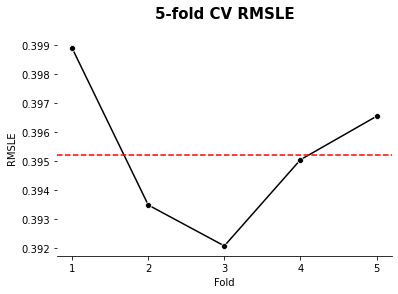

In [66]:
ax = sns.lineplot(range(1, 6), cv_result, marker = 'o', color = 'black')
plt.title('5-fold CV RMSLE', fontsize = 15, fontweight = 'bold', pad = 20)
plt.axhline(y = np.mean(cv_result), linestyle = '--', color = 'red')
plt.xticks([1, 2, 3, 4, 5]); plt.xlabel('Fold'); plt.ylabel('RMSLE')
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

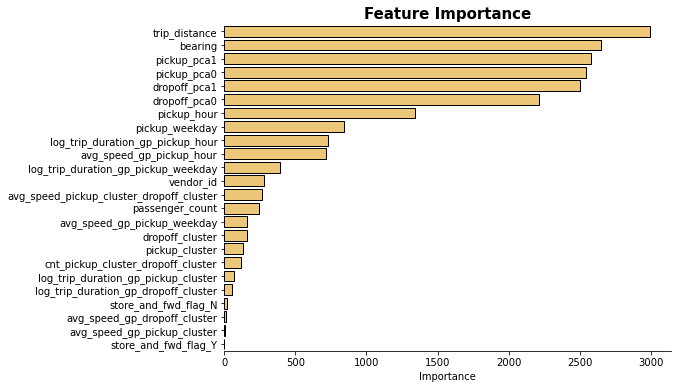

In [68]:
feat_imp = pd.DataFrame()
feat_imp['variable'] = X.columns.tolist()
feat_imp['importance'] = lgbm_model.feature_importances_
feat_imp = feat_imp.sort_values(by = 'importance', ascending = False)

plt.figure(figsize = (8, 6))
ax = sns.barplot(data = feat_imp, x = 'importance', y = 'variable', color = '#ffcc66', edgecolor = 'k')
plt.title('Feature Importance', fontsize = 15, fontweight = 'bold'); plt.ylabel(''); plt.xlabel('Importance')
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)